# Project: Milestone 2

### Description of requirement for the milestone

- That you can handle the data in its size.
- That you understand what’s into the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have updated your plan in a reasonable way, reflecting your improved knowledge after data acquaintance. In particular, discuss how your data suits your project needs and discuss the methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is now reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

### Description of internal requirement for the milestone

- Analyze the given features of Amazon reviews, Amazon metadata and FDA dataset.
- Understand existing recommendation system approaches (for example collaborative filtering, content based filtering, hybrid recommendation engine, graph based recommednation system) by reviewing many research articles.
- Look what can be improved (for example by reading the future research suggestions by the authors/ by figuring out any pitfalls in the existing work)


- Explore various NLP approaches to detect and classify possibly harmful products by analyzing user product reviews and FDA Recall Reason text.
- Compare time points of health related negative reviews and FDA product recalls.
- Append an additional rating to the positive/negative one that is provided by NLTK

## Introduction

Using Natural Language Processing (NLP) on the Amazon Grocery and Gourmet Food Product reviews database and FDA food recalls, we want to distinguish products that users like and dislike  and use time stamps to suggest the possible harmful products.

Our first plan was to directly relate products from the Amazon datasets to ones of the FDA dataset. This would have provided true-values for possible health threats found in the Amazon dataset which could have been used for training and evaluating our models. However, this would have required us to perform conversions between the ASIN (Amazon Standard Identification Number) and the UPC (Universal Product Code) of products in a large scale. Queries like this are restricted by Amazon and therefore not possible for us in our project. In consequence, we decided to still use the FDA dataset but for another purpose. We want to analyze the language in order to possibly link it to the language used in the Amazon reviews. This shall be done by NLP (natural language processing). However, doing that will not solve our problem of missing labels for the products and reviews. To lable our data, we used a work-around using lexical data of words that can be related to health issues and other features of our data.

In our data story we will try show how a general bad review of a product (i.e. because of personal taste or false expectations of the user) should be distinguished from health related ones. Using the FDA dataset will help us relating reviews to possible harmful food products. The overall goal is to enhance Amazon's user experience by considering possible health threats. For the final presentation, we hope to build a UI based data story system where we will present how the employees of amazon will have the possibility to query and distinguishing possible harmful products. This would encourage retailers to maintain quality standards, could improve quality of food products and eventually enhance health and life quality of people.

In [96]:
!ls


asins.csv			 Milestone3.ipynb  requirements.txt
cleaned_meta.json		 modelling	   results
cleaned_reviews.json		 niko.ipynb	   Review_Parser.png
data				 notebooks	   setup.py
empath				 papers		   src
histogram_year.png		 poster		   tests
histogram_year_recall.png	 README.md	   visualise_recommendation.py
histogram_year_recall_press.png  report		   website


## A.1 Data Sanitizing

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import gzip
%matplotlib inline

In [258]:
#AMAZON DATA
#REVIEWS_PATH = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/reviews_Grocery_and_Gourmet_Food.json.gz"
#META_PATH = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/meta_Grocery_and_Gourmet_Food.json.gz"
#FDA DATA
#path_press_released = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/FDA_press_released_2011_2019.csv"
#path_enforced = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/FDA_enforcements_2012-06_to_2019-10.csv"

REVIEWS_PATH = "data/02_processed/reviews_Grocery_and_Gourmet_Food_5.json.gz"
META_PATH = "data/02_processed/meta_Grocery_and_Gourmet_Food.json.gz"
path_press_released = "data/02_processed/FDA_press_released_2011_2019.csv"
path_enforced = "data/02_processed/FDA_enforcements_2012-06_to_2019-10.csv"

Before starting our data import and exploration, we first need to convert the data to strict json. As explained in the site [from which the data comes from](http://jmcauley.ucsd.edu/data/amazon/links.html), the data is not in strict json, and thus we can not import as-is in a dataframe. To avoid us the hassle of reading the file in a dictionnary everytime we want to import it in a dataframe, we are going to create new files containing the reviews and metadata in appropriate format.

In [99]:
def sanitize(path, outpath):
    """Converts a given compressed json to strict json and writes it in a new file

    Parameters
    ----------
    path : str
    The file location of the gzip-compressed json file
    outpath : str
    The path to the desired output file location 

    """
    g = gzip.open(path, 'r')

    out = open(outpath, 'w')

    for l in g:
        out.write(json.dumps(eval(l)) + '\n')
    out.close()

In [100]:
META_OUTPATH = "cleaned_meta.json"
REVIEWS_OUTPATH = "cleaned_reviews.json"

sanitize(META_PATH, META_OUTPATH)
sanitize(REVIEWS_PATH, REVIEWS_OUTPATH)

##  A.2 Data Import

Now that our data is in correct format, we can safely import it and have a quick first look.

In [101]:
REVIEWS_PATH = "cleaned_reviews.json"
META_PATH = "cleaned_meta.json"

In [102]:
# Read-in the reviews and products data
reviews = pd.read_json(REVIEWS_PATH, lines=True)
products= pd.read_json(META_PATH, lines=True)
# Final data frame obtained by mergin reviews and products
final_df=pd.merge(reviews, products, left_on='asin', right_on='asin', how='left')

For efficiency as well as memory purposes, we are going to first drop some of the columns that we are not going to use in our later analysis.

##  A.3 Understanding data

In [103]:
#Drop some of the columns
final_df = final_df.drop(columns=['reviewerName', 'helpful', 'reviewTime', 'summary','imUrl','salesRank','price','related','description','title'])

We are also convert the unixReviewTime column to the datetime type.

In [104]:
#Convert the utc timestamp to readable dates
final_df['unixReviewTime'] = pd.to_datetime(final_df['unixReviewTime'],unit='s')

final_df.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4,2013-06-01,[[Grocery & Gourmet Food]],NaN
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3,2014-05-19,[[Grocery & Gourmet Food]],NaN
2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4,2013-10-08,[[Grocery & Gourmet Food]],NaN
3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5,2013-05-20,[[Grocery & Gourmet Food]],NaN
4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4,2013-05-26,[[Grocery & Gourmet Food]],NaN


In [105]:
#Observing the shape of our data frame.
final_df.shape
# Note: We have 7 features and 1297156 data points.

(151254, 7)

In [106]:
#Lets check for missing values
final_df.info()
#Observe that there are some missing values in 'brand' column.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151254 entries, 0 to 151253
Data columns (total 7 columns):
reviewerID        151254 non-null object
asin              151254 non-null object
reviewText        151254 non-null object
overall           151254 non-null int64
unixReviewTime    151254 non-null datetime64[ns]
categories        151254 non-null object
brand             104238 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 9.2+ MB


In [107]:
final_df.describe()
#Observe that more than 75% of our data is belonging to positive /
#class, i.e. we have imbalanced dataset.

,overall
count,151254.000000
mean,4.243042
std,1.090003
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## B.1  Exploratory Data Analysis

Though our  work involves working on review text scores, we do a preliminary analysis based on overall score [1-5] Lets do the value count on 'Scores' for now.


In [108]:
# Count overall scores based on
final_df.overall.value_counts()

5    87446
4    32598
3    17514
2     7917
1     5779
Name: overall, dtype: int64

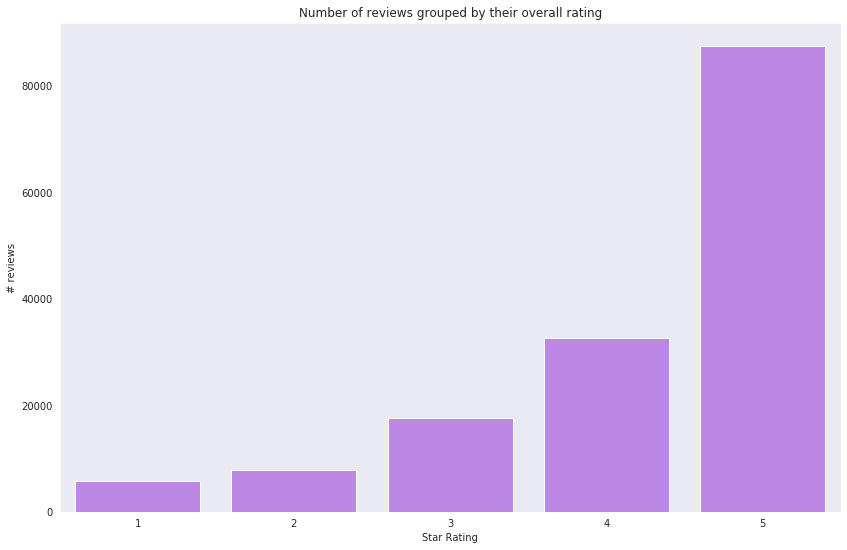

In [109]:
#Importing Seaborn and Matplotlib for graphical effects.
# Below we plot number of reviewers based on rating
import matplotlib.pyplot as plt
import seaborn as sns
light_purple = sns.xkcd_rgb["light purple"]
plt.figure(figsize=(14,9))
sns.countplot(x='overall', data=final_df, color=light_purple)
plt.xlabel('Star Rating')
plt.ylabel('# reviews')
plt.title('Number of reviews grouped by their overall rating')
plt.show()

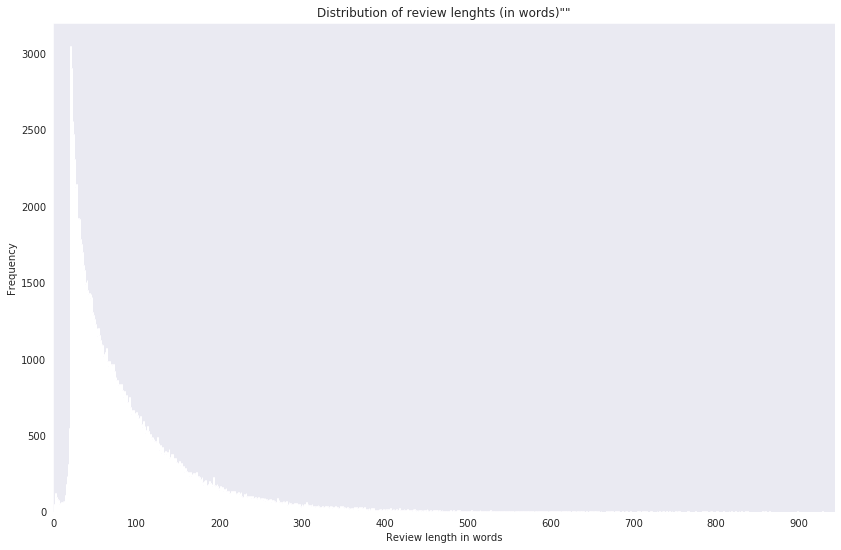

In [253]:
final_df["text_word_count"] = final_df["reviewText"].apply(lambda text: len(text.split()))
plt.figure(figsize=(14,9))
sns.countplot(x='text_word_count', data=final_df, color=light_purple)
plt.xlabel('Review length in words')
plt.xticks(np.arange(0,1000,100),np.arange(0,1000,100))
plt.ylabel('Frequency')
plt.title('Distribution of review lenghts (in words)""')
plt.show()

In [111]:
final_df["text_word_count"].describe()

count    151254.000000
mean         93.093445
std          92.543555
min           0.000000
25%          36.000000
50%          66.000000
75%         118.000000
max        4693.000000
Name: text_word_count, dtype: float64

In [112]:
final_df[final_df.overall==5].text_word_count.median()


55.0

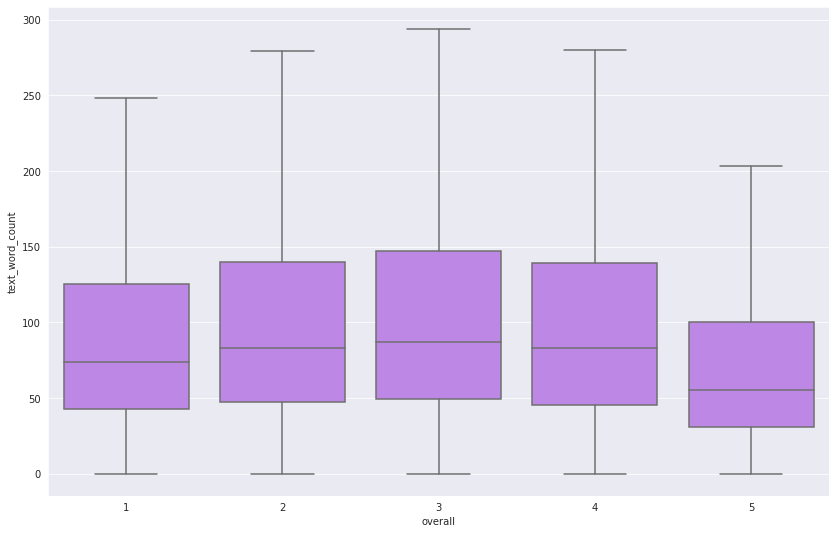

In [113]:
plt.figure(figsize=(14,9))
sns.set_style("dark")
sns.boxplot(x='overall',y='text_word_count', data=final_df, color=light_purple, showfliers=False)
plt.grid(axis="y")

## B.3 Frequency of reviewers


In [114]:

freq_user = final_df.reviewerID.value_counts()
freq_user.to_dict()
print("converted Series to dictionary")

converted Series to dictionary


In [115]:
final_df["reviewer_freq"] = final_df["reviewerID"].apply(lambda counts: "Frequent (>50 reviews)" \
                                                                 if freq_user[counts]>50 else "Not Frequent (1-50)")

## B.4 Are frequent reviewers more verbose?

The distributions of word counts for frequent and infrequent reviews shows that infrequent reviewers have a large amount of reviews of low word count. On the other hand, the largest concentration of word count is higher for frequent reviewers than for infrequent reviews. Moreover, the median word count for frequent reviewers is higher than the median for infrequent reviewers.

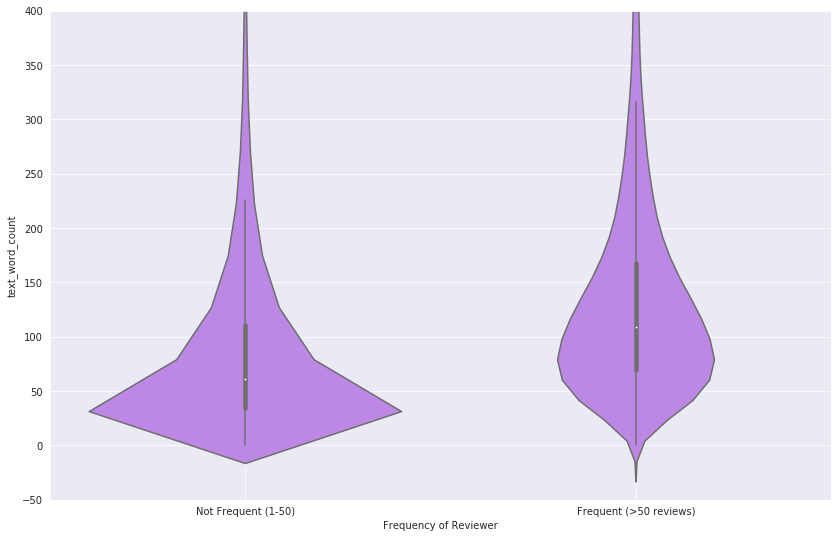

In [116]:
plt.figure(figsize=(14,9))

sns.violinplot(x='reviewer_freq', y='text_word_count',  \
               data=final_df, color=light_purple)
plt.xlabel('Frequency of Reviewer')
plt.ylim(-50, 400)
plt.grid("y")


## B.5 Review text Analysis

In [117]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import gensim
import collections
from afinn import Afinn
%matplotlib inline






##Remove special characters from the review text
final_df['reviewText'] = final_df['reviewText'].str.replace("'", "")
final_df['reviewText'] = final_df['reviewText'].str.replace('[^a-zA-Z\s]',' ')




#Download stopwords and wordnet for lemmatization (only need to be executed once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/embolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/embolo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [118]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

stop_words = set(stopwords.words('english')) 

# Here we don't need stemming, because Afinn has same score for the before stemmed ones.
# stemmer = PorterStemmer()

def process_text(sentence):
    token_words = nltk.word_tokenize(sentence)
    no_stopwords = [word.lower() for word in token_words if word not in stop_words and not \
                    all(c in string.punctuation for c in word) and not len(word) < 2]
    # return [stemmer.stem(word) for word in no_stopwords]
    return [(word) for word in no_stopwords]

print(process_text('I ordered spongbob slippers and I got John'))

[nltk_data] Downloading package stopwords to /home/embolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['ordered', 'spongbob', 'slippers', 'got', 'john']


In [203]:
stemmed = final_df.copy()
stemmed = stemmed[stemmed['overall'] < 3]
stemmed['reviewStemmed'] = stemmed['reviewText'].apply(lambda x : process_text(x))

stemmed.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed
9,A33NXNZ79H5K51,616719923X,I love green tea I love Kit Kats but the two...,1,2012-09-19,[[Grocery & Gourmet Food]],NaN,22,Not Frequent (1-50),"[love, green, tea, love, kit, kats, two, belon..."
32,A14YSMLYLJEMET,B00004S1C5,This product is no where near natural organi...,1,2013-03-29,"[[Grocery & Gourmet Food, Cooking & Baking, Fo...",HIC Harold Import Co.,103,Not Frequent (1-50),"[this, product, near, natural, organic, wish, ..."
75,A3OH4OZFZGEH75,B0000CCZYY,Licorice is my favorite candy and it promotes...,1,2013-04-05,[[Grocery & Gourmet Food]],Panda,93,Not Frequent (1-50),"[licorice, favorite, candy, promotes, good, di..."
82,A2OUNVRPRWH0,B0000CCZYY,This is an awesome product natural not a lot...,1,2013-05-07,[[Grocery & Gourmet Food]],Panda,185,Not Frequent (1-50),"[this, awesome, product, natural, lot, ingredi..."
85,AX04H2SPKO02S,B0000CD06J,As soon as I had a couple of sips my eczema s...,1,2013-03-06,"[[Grocery & Gourmet Food, Beverages, Coffee, C...",Cafix,33,Not Frequent (1-50),"[as, soon, couple, sips, eczema, started, unco..."


In [204]:
def flatten(nested_list):
    return [e for inner_list in nested_list for e in inner_list]

In [205]:
l_stemmed = stemmed['reviewStemmed'].values.tolist()
l_stemmed = flatten(l_stemmed)

In [211]:
frequentWords = collections.Counter(l_stemmed).most_common()[0:50000]
frequentWords = [word for word, count in frequentWords]


## B.6 Zipf's Law

Zipf's law is an empirical law formulated using mathematical statistics. The law is named after the linguist George Kingsley Zipf, who first proposed it

Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Another way to state Zipf's law is: small number of words are used all the time, while majority of words are used rarely

In [212]:
frequentWords = collections.Counter(l_stemmed).most_common()
df = pd.DataFrame(frequentWords, columns = ['FrequentWords' , 'Count']).set_index('FrequentWords')

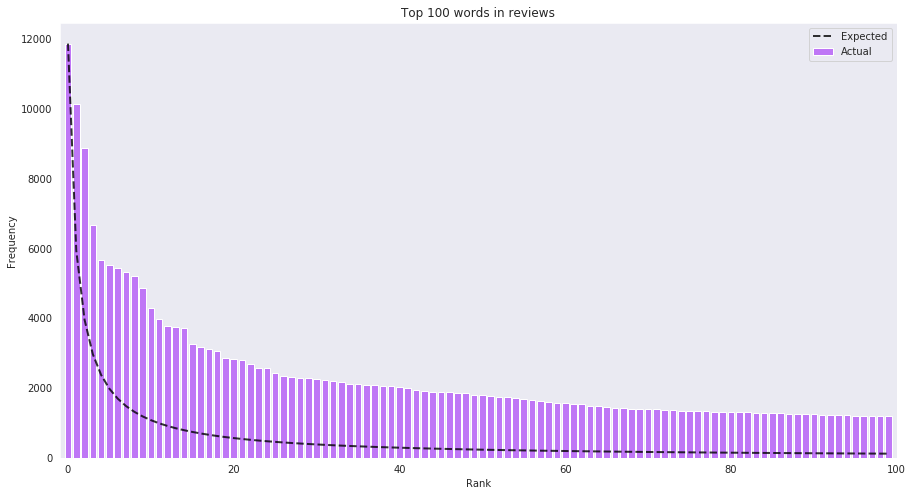

In [213]:
n_words = 100
x = np.arange(n_words)
y = df.iloc[:n_words, 0]
most_frequent_word = y[0]
expected_zipf = [most_frequent_word / (i + 1) for i in range(n_words)]

plt.figure(figsize=(15, 8))
plt.bar(x, y, alpha=1, color=light_purple)
plt.plot(x, expected_zipf, color='black', linestyle='--', linewidth=2, alpha=0.8)

plt.xlim([-1, n_words])
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Top {} words in reviews'.format(n_words))
plt.legend(['Expected', 'Actual'])



X axis is rank of frequency from highest rank from left up to 100th rank to the right.

Y axis is frequency of words in given corpus.

We can see that plot follows the trend of Zipf's law. Actual observations in most cases does not strictly follow Zipf’s distribution, but rather follow a trend of “near-Zipfian” distribution.


# C Labelling data

Using the Amazon dataset, our goal is to detect any potential harmful products by analyzing the user reviews and classifying them as presenting or not a possible health threat. Unfortunately, we lack the annotated data that would be needed to build a classifier.

We will thus create our own annotated data by using **empath** ,**affin** and  **fda recall reason text** . **Empath** is a python library that can be used to analyze documents over a set of predefined categories, and even generate new categories. **Affin** is a python library which gives the ability to append and overwrite word / value pairs from the AFINN wordlist  rated for valence with an integer between minus five (negative) and plus five (positive). Sentiment analysis is performed by cross-checking the string tokens (words, emojis) with the AFINN list and getting their respective scores. **FDA recall** we use two fda datasets: Fda enforcement and fda press release, using which we build a list of words (library) by parsing fda recall reason text.

We start by importing the affin library.

## C.1 Labeling the amazon reviews with empath sentiment analysis.

Empath is a tool for analyzing text across lexical categories (similar to LIWC), and also generating new lexical categories to use for an analysis. Empath draws connotations between words and phrases by deep learning a neural embedding across more than 1.8 billion words of modern fiction. Given a small set of seed words that characterize a category, Empath uses its neural embedding to discover new related terms, then validates the category with a crowd-powered filter. Empath also analyzes text across 200 built-in, pre-validated categories we have generated from common topics in our web dataset, like neglect, government, and social media.



In [214]:
from empath import Empath

We then create a new lexical category **healthConcerns** as a combination of the seeds words **health**, **danger** and **food poisoning**.

In [215]:
lexicon = Empath()

lexicon.create_category('healthConcerns', \
                        seeds=['health', 'danger', 'food poisoning'])


["health", "danger", "welfare", "human_life", "illness", "sickness", "necessity", "safety", "responsibility", "mental_state", "dangers", "well-being", "risk", "lifemate", "knowledge", "survival", "consequence", "humanity", "recovery", "exposure", "risks", "capacity", "wellbeing", "peril", "potential", "responsibilities", "downfall", "death", "loyalty", "bloodline", "fear", "judgement", "poverty", "responsible", "threat", "condition", "importance", "treatment", "current_state", "disease", "discipline", "top_priority", "judgment", "affairs", "healing", "cruelty", "human_race", "sacrifice", "ensure", "demise", "hardship", "separation", "vital", "healer", "losses", "likelihood", "environment", "Psy", "hazard", "corruption", "independence", "future", "own_safety", "needs", "killing", "normalcy", "Council", "suffering", "stability", "virtue", "disability", "sacrifices", "conditions", "free_will", "failure", "therefore", "carelessness", "involvement", "mindset", "unborn_child", "relations", "

In [216]:
def analyze(x):
    ret = lexicon.analyze(x, categories=["healthConcerns"])
    if (ret == None):
        return 0.0
    else:
        return ret.get('healthConcerns')

We now create a new column do our dataframe, obtained by analyzing the reviews and assigning them a score. The higher the score is, the more that review exposes possible health concerns. 

In [217]:
empathy = final_df.copy()
empathy['healthScore'] = empathy['reviewText'].apply(lambda x : analyze(x))

empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4,2013-06-01,[[Grocery & Gourmet Food]],NaN,31,Not Frequent (1-50),0.0
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3,2014-05-19,[[Grocery & Gourmet Food]],NaN,114,Not Frequent (1-50),0.0
2,A27IQHDZFQFNGG,616719923X,Really good Great gift for any fan of green t...,4,2013-10-08,[[Grocery & Gourmet Food]],NaN,20,Not Frequent (1-50),0.0
3,A31QY5TASILE89,616719923X,I had never had it before was curious to see ...,5,2013-05-20,[[Grocery & Gourmet Food]],NaN,30,Not Frequent (1-50),0.0
4,A2LWK003FFMCI5,616719923X,Ive been looking forward to trying these after...,4,2013-05-26,[[Grocery & Gourmet Food]],NaN,108,Not Frequent (1-50),0.0


Now that all our reviews have been assign a score, let's have a look at its distribution.

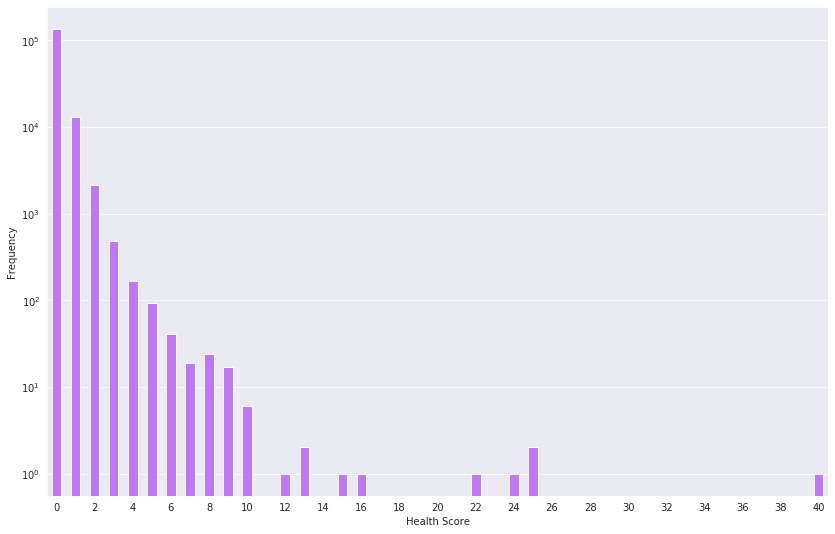

In [218]:
plt.figure(figsize=(14,9))
empathy.groupby(by='healthScore') \
        .count()['reviewText'] \
        .reindex(list(range(41))) \
        .fillna(0) \
        .plot.bar(rot=0, color=light_purple, log=True)
plt.xticks(range(0,41,2),range(0,41,2))
plt.xlabel("Health Score")
plt.ylabel("Frequency")
plt.grid(axis="y")

As expected, we observe that a vast majority of the reviews don't expose any kind of health-related issues (symbolized by the pic at x = 0). Let's dive deeper and have a closer look at the reviews with a score bigger than 0.

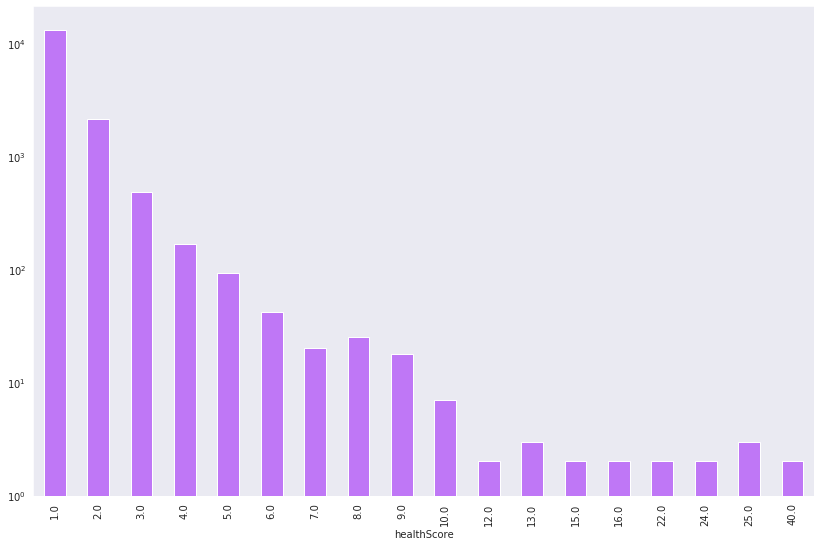

In [219]:
plt.figure(figsize=(14,9))
empathyScore = empathy[empathy['healthScore'] > 0]

empathyScore.groupby(by='healthScore').count()['reviewText'].plot.bar(color=light_purple, log=True)
# the following plot is not needed anymore as the previous one contains the same information

Text(0.5, 1.0, 'Health Score per overall Rating')

<Figure size 1296x648 with 0 Axes>

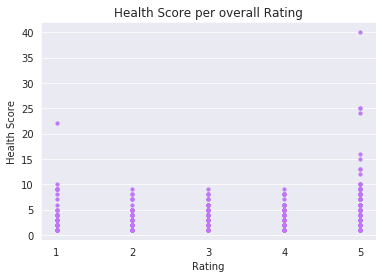

In [220]:
plt.figure(figsize=(18,9))
empathyScore.plot.scatter('overall', 'healthScore', s=10,c=light_purple)
plt.xticks(range(1,6,1),range(1,6,1))
plt.xlabel("Rating")
plt.ylabel("Health Score")
plt.grid(axis="y")
plt.title("Health Score per overall Rating")

We observe here something pretty unexpected : most of the reviews with a high healthScore have an associated rating of 3 or more, with the highest healthScore at x=5. A fair assumption would be that a reviewer exposed to health issues due to a product would attribute it a low score, which is not the case here. Let's have a look at the reviews themselves now, to gain more insights.

In [221]:
empathyScore[empathyScore['overall'] == 5].sort_values(by='healthScore', ascending=False).head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore
42764,A1J7FP5XCCSHSM,B001AG6BMO,Uses for Coconut Oil Coconut Oil Is Anti b...,5,2012-03-22,"[[Grocery & Gourmet Food, Cooking & Baking, Co...",Garden of Life,4693,Not Frequent (1-50),40.0
146626,AUYT2H281GPNJ,B00DS842HS,Well the wife and I have been using coconut o...,5,2013-10-02,[[Grocery & Gourmet Food]],Viva Labs,1379,Not Frequent (1-50),25.0
31567,A356RFKNIG043B,B000R71WMQ,I cant begin to praise apple cider vinegar ac...,5,2014-04-05,[[Grocery & Gourmet Food]],Bragg,1394,Not Frequent (1-50),25.0
49338,A3RR2P5IS3DGPR,B001ELL288,These Eden Dried Montmorency Cherries are perf...,5,2010-06-11,[[Grocery & Gourmet Food]],Eden,1468,Frequent (>50 reviews),24.0
97725,A2L73KNIMIF3TY,B004EKHN4I,I have been consuming this product for over ...,5,2013-06-20,[[Grocery & Gourmet Food]],NaN,436,Not Frequent (1-50),16.0


In [222]:
[x[:1000] for x in empathyScore[empathyScore['overall'] == 5] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:2]]

['    Uses for Coconut Oil Coconut Oil Is Anti bacterial  kills bacteria that cause ulcers  throat infections  urinary tract infections  gum diseases  and other bacterial infections Anti carcinogenic  coconut oil has antimicrobial properties so it effectively prevents the spread of cancer cells and enhances the immune system Anti fungal  kills fungi and yeast that lead to infection Anti inflammatory  appears to have a direct effect in suppressing inflammation and repairing tissue  and it may also contribute by inhibiting harmful intestinal microorganisms that cause chronic inflammation  Anti microbial Infection Fighting  the medium chain fatty acids and monoglycerides found in coconut oil are the same as those in human mothers milk  and they have extraordinary antimicrobial properties  By disrupting the lipid structures of microbes  they inactivate them  About half of coconut oil consists of lauric acid  Lauric acid  its metabolite monolaurin and other fatty acids in coconut oil are kn

As we see with those reviews, there seems to be something off with them (note that, for readability purposes, we only show the first thousand characters of those reviews) : they look more like some ad of the product's benefits/usages than actual reviews. Our initial assumption seems thus accurate : even though those "reviews" are health-related, they are not what we are looking for. We are thus going to ignore them. Let's continue our analysis with the reviews with score 3 and 4.

In [223]:
[x[:1000] for x in \
 empathyScore[empathyScore['overall'] == 4] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:3]]

['This is not organic but an excellent start in an  oz bag  There are few reviews on this particular  oz Navitas product that need correction     oz bag will stay fresher than a   oz bag so these are  oz bags not   oz which is better especially with Amazon high turn over    I consume lots of hemp due to the oil in hemp and majority taste almost the same but certainly not the same even from the same producer since it is a natural product with oil  organic always tastes different than conventional as well regardless    Navitas happens to be an high end brand regardless of whatever that they sell due to their high standards  Navitas does not gas their bags for a longer shelf life  Navitas sells variety of food items with high quality control although that they have had many issues with their Chia seeds for unknown reasons    Hemp is no replacement for almonds like one reviewer claims  almond are the king for vitamin E  others only wish    No food including hemp helps with weight loss  wat

In [224]:
[x[:1000] for x in \
 empathyScore[empathyScore['overall'] == 3] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:3]]

['This is a five star product only if you consume all five pounds of it quickly or share it with others since time is matter of essence for any seed with high oil content  This is organic      a pound which is very reasonable  I do not buy this any more since Nutiva sells the same thing in  lb for only a dollar more for a pound  Any seed that I consume needs to be fresh since going rancid means worthless so the  lb Nutiva is the perfect buy for me GENERAL  No  these will not make you high mentally but yet I get high physically since three tablespoon of this beauty  once again only   tablespoon which is    gr  offer me     magnesium and     zinc which allows me to get to really high spots in the mountains with my mountain bike or catch those big high waves in the ocean since my muscles do not cramp due to magnesium intake of hemp seeds  What an absolute joke  in US they continuously talk about health care but yet this one creation of nature which offers so much not only is not produced 

We see that reviews with a 4 score don't really assert the reviewed product's health issues, but its competitors or other aspects. Whereas the reviews rated 3-stars seem to correspond to what we were looking for.

Thus, for our labelled data, we're going to limit ourselves to the reviews with a healthScore strictly positive, and with a rating smaller or equal to 3.

In [225]:
empathy['danger'] = np.where(np.logical_and(empathy['healthScore'] > 0., empathy['overall'] < 4), \
                             1, np.nan)


empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore,danger
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4,2013-06-01,[[Grocery & Gourmet Food]],NaN,31,Not Frequent (1-50),0.0,NaN
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3,2014-05-19,[[Grocery & Gourmet Food]],NaN,114,Not Frequent (1-50),0.0,NaN
2,A27IQHDZFQFNGG,616719923X,Really good Great gift for any fan of green t...,4,2013-10-08,[[Grocery & Gourmet Food]],NaN,20,Not Frequent (1-50),0.0,NaN
3,A31QY5TASILE89,616719923X,I had never had it before was curious to see ...,5,2013-05-20,[[Grocery & Gourmet Food]],NaN,30,Not Frequent (1-50),0.0,NaN
4,A2LWK003FFMCI5,616719923X,Ive been looking forward to trying these after...,4,2013-05-26,[[Grocery & Gourmet Food]],NaN,108,Not Frequent (1-50),0.0,NaN


In [226]:
print("Number of reviews that we will use as positive labelled data : {}" \
      .format(len(empathy[empathy['danger'] == 1])))

Number of reviews that we will use as positive labelled data : 3755


For the negative examples (i.e. the reviews that don't present any health danger), we are simply going to select a random sample of the reviews with a health score of 0.

In [227]:
negative_sample = empathy[empathy['danger'].isna()].sample(frac=0.1, random_state=10)

print("Size of the sample : {}".format(len(negative_sample)))

negative_sample.head()

Size of the sample : 14750


,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore,danger
92412,AF5AJ5V9T6LTS,B0044QYG2E,these are made in Spain and are decent Better...,3,2011-11-16,[[Grocery & Gourmet Food]],Haribo,31,Not Frequent (1-50),0.0,NaN
70125,A3TZ3MTHOAVN59,B002DHNBAO,Raisins are a decent source of potassium and ...,4,2014-01-26,[[Grocery & Gourmet Food]],Raisin Bran,49,Not Frequent (1-50),0.0,NaN
57478,A3DAIA8AJNHK1B,B001JDQ4Q6,I had previously only had Godiva truffles so ...,5,2012-12-23,[[Grocery & Gourmet Food]],NaN,88,Not Frequent (1-50),0.0,NaN
126189,AJ329F9H546BM,B007JFXWRC,As someone who usually does not drink herbal t...,5,2012-10-30,[[Grocery & Gourmet Food]],Lipton,48,Not Frequent (1-50),0.0,NaN
37133,AZV3KWJRFXLAX,B00113ZZ5U,Just right for cooking drinks and to add to r...,5,2013-02-10,[[Grocery & Gourmet Food]],Let&#39;s Do Organic,19,Not Frequent (1-50),0.0,NaN


Now that we have our negative sample, let's update our original dataframe : we are going to associate the label 0 to the sampled reviews

In [228]:
empathy['danger'] = np.where(empathy['reviewText'].isin(negative_sample['reviewText']), \
                            0, empathy['danger'])

empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore,danger
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4,2013-06-01,[[Grocery & Gourmet Food]],NaN,31,Not Frequent (1-50),0.0,NaN
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3,2014-05-19,[[Grocery & Gourmet Food]],NaN,114,Not Frequent (1-50),0.0,0.0
2,A27IQHDZFQFNGG,616719923X,Really good Great gift for any fan of green t...,4,2013-10-08,[[Grocery & Gourmet Food]],NaN,20,Not Frequent (1-50),0.0,NaN
3,A31QY5TASILE89,616719923X,I had never had it before was curious to see ...,5,2013-05-20,[[Grocery & Gourmet Food]],NaN,30,Not Frequent (1-50),0.0,NaN
4,A2LWK003FFMCI5,616719923X,Ive been looking forward to trying these after...,4,2013-05-26,[[Grocery & Gourmet Food]],NaN,108,Not Frequent (1-50),0.0,NaN


Let's ensure that it indeed worked :

In [229]:
print("""Number of reviews that we will use as positive labelled data : {},
       and as negative samples : {}"""
      .format(len(empathy[empathy['danger'] == 1]), len(empathy[empathy['danger'] == 0])))

Number of reviews that we will use as positive labelled data : 3755,
       and as negative samples : 14786


In [230]:
empathy.to_pickle('empath')

## C.2 Labeling the amazon reviews with Afinn sentiment analysis.

In [231]:
afinn = Afinn()

# Compute affin score for all the stemmed words
stemmed['afinnWords'] = stemmed['reviewText'].apply(lambda x : afinn.find_all(x))
stemmed['afinnScores'] = stemmed['reviewText'].apply(lambda x : afinn.scores_with_pattern(x))
stemmed['afinnTotalScore'] = stemmed['reviewText'].apply(lambda x : afinn.score_with_pattern(x))
stemmed['afinnWordsLen'] = stemmed['afinnWords'].apply(lambda x : len(x))

In [232]:
stemmed['afinnMeanScore'] = (stemmed['afinnTotalScore']/stemmed['afinnWordsLen']).round()

In [233]:
stemmed.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed,afinnWords,afinnScores,afinnTotalScore,afinnWordsLen,afinnMeanScore
9,A33NXNZ79H5K51,616719923X,I love green tea I love Kit Kats but the two...,1,2012-09-19,[[Grocery & Gourmet Food]],NaN,22,Not Frequent (1-50),"[love, green, tea, love, kit, kats, two, belon...","[love, love, hate]","[3, 3, -3]",3.0,3,1.0
32,A14YSMLYLJEMET,B00004S1C5,This product is no where near natural organi...,1,2013-03-29,"[[Grocery & Gourmet Food, Cooking & Baking, Fo...",HIC Harold Import Co.,103,Not Frequent (1-50),"[this, product, near, natural, organic, wish, ...","[no, natural, wish, want, natural, avoid, avoi...","[-1, 1, 1, 1, 1, -1, -1, 2, 2]",5.0,9,1.0
75,A3OH4OZFZGEH75,B0000CCZYY,Licorice is my favorite candy and it promotes...,1,2013-04-05,[[Grocery & Gourmet Food]],Panda,93,Not Frequent (1-50),"[licorice, favorite, candy, promotes, good, di...","[favorite, promotes, good, stronger, nice, ter...","[2, 1, 3, 2, 3, -3, 2]",10.0,7,1.0
82,A2OUNVRPRWH0,B0000CCZYY,This is an awesome product natural not a lot...,1,2013-05-07,[[Grocery & Gourmet Food]],Panda,185,Not Frequent (1-50),"[this, awesome, product, natural, lot, ingredi...","[awesome, natural, good, sweet, no, love, hone...","[4, 1, 3, 2, -1, 3, 2, -2, -2, -2, -3, 1, -2, ...",7.0,19,0.0
85,AX04H2SPKO02S,B0000CD06J,As soon as I had a couple of sips my eczema s...,1,2013-03-06,"[[Grocery & Gourmet Food, Beverages, Coffee, C...",Cafix,33,Not Frequent (1-50),"[as, soon, couple, sips, eczema, started, unco...",[free],[1],1.0,1,1.0


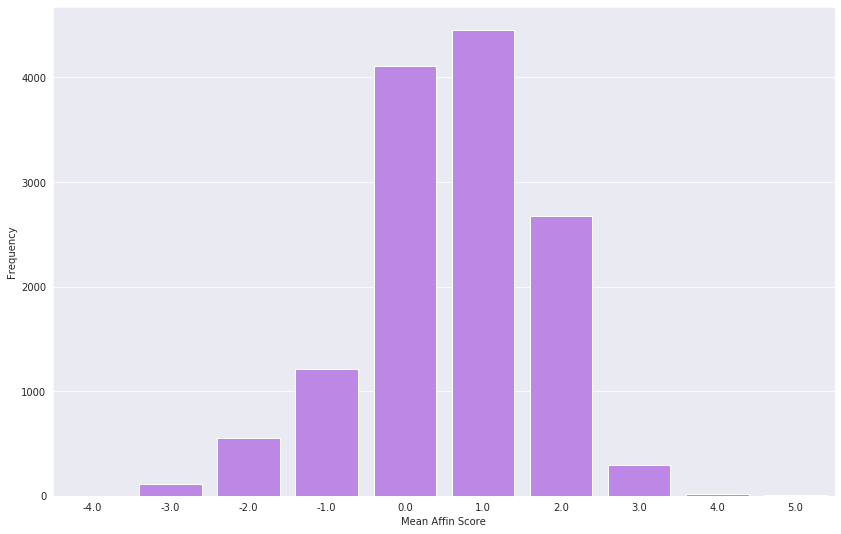

In [252]:
plt.figure(figsize=(14,9))
sns.countplot(x='afinnMeanScore', data=stemmed, color=light_purple)
plt.xlabel('Mean Affin Score')
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.Title("Mean Affin Score distribution of the reviews using all words")
plt.show()

In [235]:
# With using wordcloud library, make a function visualizes the words in these two lists
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(14, 9))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.5)

    plt.imshow(wordcloud)
    plt.show()

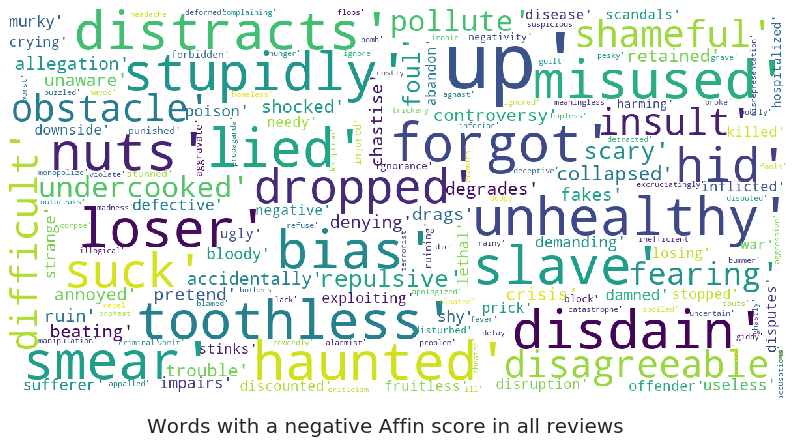

In [236]:
l_words = stemmed['afinnWords'].values.tolist()
l_words = flatten(l_words)
l_scores = stemmed['afinnScores'].values.tolist()
l_scores = flatten(l_scores)
words_scores = list(zip(l_words, l_scores))
negative_scores = set([word for word, score in words_scores if score<0])
show_wordcloud(negative_scores, title = "Words with a negative Affin score in all reviews")


In [237]:
# Compute affin score for all the frequent stemmed words

frequentWords = [word for word, count in frequentWords]

stemmed_frequent = stemmed.copy()
stemmed_frequent['afinnWords'] = stemmed['afinnWords'].apply(lambda x : [i for i in x if i in frequentWords])
stemmed_frequent['afinnScores'] = stemmed_frequent['reviewText'].apply(lambda x : afinn.scores_with_pattern(x))
stemmed_frequent['afinnTotalScore'] = stemmed_frequent['reviewText'].apply(lambda x : afinn.score_with_pattern(x))
stemmed_frequent['afinnWordsLen'] = stemmed_frequent['afinnWords'].apply(lambda x : len(x))

In [238]:
stemmed_frequent['afinnMeanScore'] = (stemmed_frequent['afinnTotalScore']/stemmed_frequent['afinnWordsLen']).round()

In [240]:
stemmed_frequent.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed,afinnWords,afinnScores,afinnTotalScore,afinnWordsLen,afinnMeanScore
9,A33NXNZ79H5K51,616719923X,I love green tea I love Kit Kats but the two...,1,2012-09-19,[[Grocery & Gourmet Food]],NaN,22,Not Frequent (1-50),"[love, green, tea, love, kit, kats, two, belon...","[love, love, hate]","[3, 3, -3]",3.0,3,1.0
32,A14YSMLYLJEMET,B00004S1C5,This product is no where near natural organi...,1,2013-03-29,"[[Grocery & Gourmet Food, Cooking & Baking, Fo...",HIC Harold Import Co.,103,Not Frequent (1-50),"[this, product, near, natural, organic, wish, ...","[no, natural, wish, want, natural, avoid, avoi...","[-1, 1, 1, 1, 1, -1, -1, 2, 2]",5.0,9,1.0
75,A3OH4OZFZGEH75,B0000CCZYY,Licorice is my favorite candy and it promotes...,1,2013-04-05,[[Grocery & Gourmet Food]],Panda,93,Not Frequent (1-50),"[licorice, favorite, candy, promotes, good, di...","[favorite, promotes, good, stronger, nice, ter...","[2, 1, 3, 2, 3, -3, 2]",10.0,7,1.0
82,A2OUNVRPRWH0,B0000CCZYY,This is an awesome product natural not a lot...,1,2013-05-07,[[Grocery & Gourmet Food]],Panda,185,Not Frequent (1-50),"[this, awesome, product, natural, lot, ingredi...","[awesome, natural, good, sweet, no, love, hone...","[4, 1, 3, 2, -1, 3, 2, -2, -2, -2, -3, 1, -2, ...",7.0,19,0.0
85,AX04H2SPKO02S,B0000CD06J,As soon as I had a couple of sips my eczema s...,1,2013-03-06,"[[Grocery & Gourmet Food, Beverages, Coffee, C...",Cafix,33,Not Frequent (1-50),"[as, soon, couple, sips, eczema, started, unco...",[free],[1],1.0,1,1.0


In [241]:
stemmed_frequent['afinnMeanScore']= stemmed_frequent['afinnMeanScore'].replace([np.inf, -np.inf], np.nan)

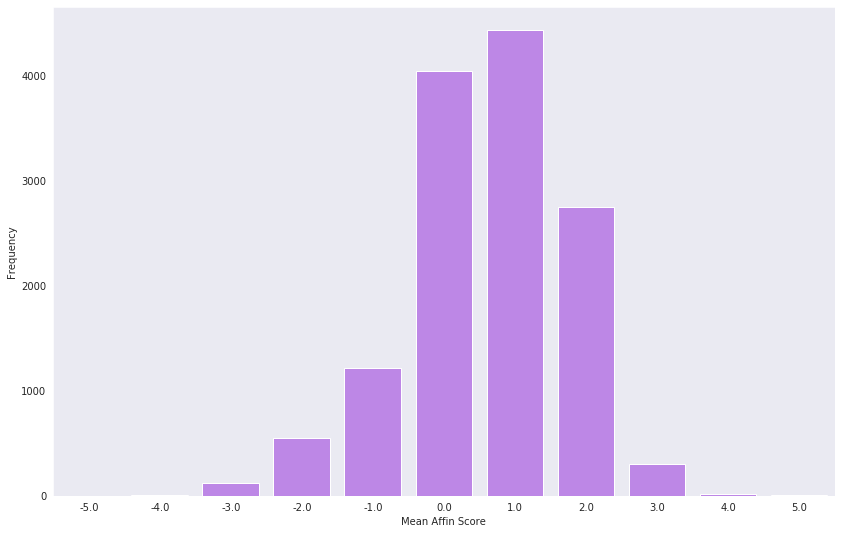

In [246]:
plt.figure(figsize=(14,9))
sns.countplot(x='afinnMeanScore', data=stemmed_frequent, color=light_purple)
plt.xlabel('Mean Affin Score')
plt.ylabel('Frequency')
plt.show()

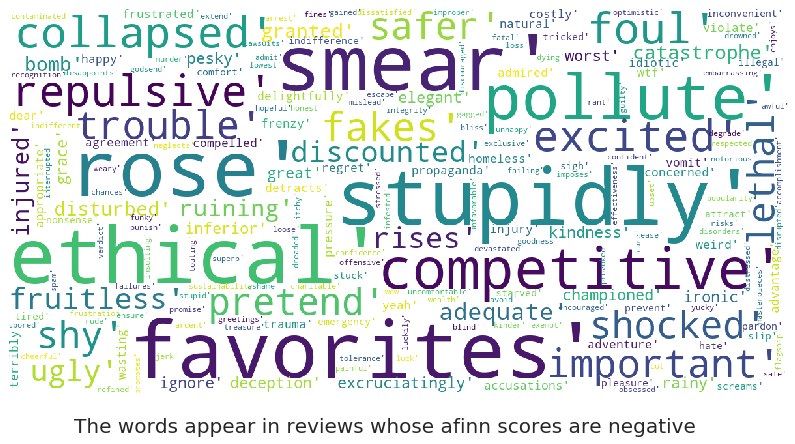

In [254]:
l_words = stemmed_frequent['afinnWords'].values.tolist()
l_words = flatten(l_words)
l_scores = stemmed_frequent['afinnScores'].values.tolist()
l_scores = flatten(l_scores)
words_scores = list(zip(l_words, l_scores))
negative_scores = set([word for word, score in words_scores if score<0])
show_wordcloud(negative_scores, title = "The words appear in reviews whose afinn scores are negative")


In [255]:
stemmed_frequent.groupby(by=['afinnWordsLen']).describe()

overall                                               \
                count      mean       std  min  25%  50%  75%  max   
afinnWordsLen                                                        
0               267.0  1.531835  0.499923  1.0  1.0  2.0  2.0  2.0   
1               820.0  1.557317  0.497007  1.0  1.0  2.0  2.0  2.0   
2              1302.0  1.581413  0.493517  1.0  1.0  2.0  2.0  2.0   
3              1548.0  1.562016  0.496300  1.0  1.0  2.0  2.0  2.0   
4              1455.0  1.560825  0.496457  1.0  1.0  2.0  2.0  2.0   
...               ...       ...       ...  ...  ...  ...  ...  ...   
74                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
77                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
107               1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
137               1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
249               1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0   

              text_word_count               ... afinnTotalScore         \
                        count         mean  ...             75%    max   
afinnWordsLen                               ...                          
0                       267.0    30.580524  ...            0.00    0.0   
1                       820.0    36.091463  ...            2.00    5.0   
2                      1302.0    41.070661  ...            4.00    8.0   
3                      1548.0    49.848837  ...            4.25   10.0   
4                      1455.0    61.879725  ...            6.00   13.0   
...                       ...          ...  ...             ...    ...   
74                        1.0   409.000000  ...          133.00  133.0   
77                        1.0   991.000000  ...           -5.00   -5.0   
107                       1.0  1063.000000  ...           64.00   64.0   
137                       1.0  2037.000000  ...          191.00  191.0   
249                       1.0  3368.000000  ...          383.00  383.0   

              afinnMeanScore                                                 
                       count      mean       std  min   25%  50%   75%  max  
afinnWordsLen                                                                
0                        0.0       NaN       NaN  NaN   NaN  NaN   NaN  NaN  
1                      820.0  0.713415  2.146540 -5.0 -1.25  2.0  2.00  5.0  
2                     1302.0  0.582949  1.487468 -4.0  0.00  0.0  2.00  4.0  
3                     1548.0  0.543282  1.280882 -3.0  0.00  1.0  1.25  3.0  
4                     1455.0  0.589003  1.158137 -3.0  0.00  1.0  2.00  3.0  
...                      ...       ...       ...  ...   ...  ...   ...  ...  
74                       1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0  
77                       1.0  0.000000       NaN -0.0 -0.00 -0.0 -0.00 -0.0  
107                      1.0  1.000000       NaN  1.0  1.00  1.0  1.00  1.0  
137                      1.0  1.000000       NaN  1.0  1.00  1.0  1.00  1.0  
249                      1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0  

[67 rows x 32 columns]

## C.3 Labeling the amazon reviews with FDA Recall data sets.

We worked on creating a NLP model to detect reviews about health issues from Amazon reviews. Here, we create verify data to confirm whether the detected results are really related to health problems and whether there are any omissions.
FDA (The Food and Drug Administration) is responsible for protecting the public health by ensuring the safety, efficacy, and security of human and veterinary drugs, biological products, and medical devices; and by ensuring the safety of our nation's food supply, cosmetics, and products that emit radiation. A recall is a method of removing or correcting products that are in violation of laws administered by the FDA.
Here, we have data on foods that have been recalled by the FDA in the past, together with recall reason statements. By extracting a word that has been referred to a plurality of times from among the words described in the recall reasoning sentence, it is possible to detect a word related to health in a review about food.

In [260]:
df_press_released = pd.read_csv(path_press_released)
df_enforced = pd.read_csv(path_enforced, encoding = 'unicode_escape')

In [261]:
stemmed_press_released = df_press_released.copy()
stemmed_press_released['stemmed_Reason'] = stemmed_press_released['Reason'].astype(str).apply(lambda x : process_text(x))
stemmed_enforced = df_enforced.copy()
stemmed_enforced['stemmed_Reason.for.Recall'] = stemmed_enforced['Reason.for.Recall'].astype(str).apply(lambda x : process_text(x))

In [262]:
stemmed_press_released.head()

,Unnamed: 0,Date,Brand,ProductDescription,Reason,Company,Url,stemmed_Reason
0,0,"Sat, 31 Dec 2011 22:37:00 -0500","Let&#39;s Grow Healthy Together!, Green Valley...",Sprouts,Listeria monocytogenes,Green Valley Food Corp.,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
1,1,"Sat, 31 Dec 2011 00:00:00 -0500",Edelweiss Creamery,cheese,Listeria monocytogenes,Alpine Slicing and Cheese Conversion,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
2,2,"Sat, 31 Dec 2011 00:00:00 -0500",Brennan&#39;s Cellars,Cheese,Listeria monocytogenes,Alpine Slicing and Cheese Conversion,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
3,3,"Fri, 30 Dec 2011 00:00:00 -0500",Martinelli&#39;s Gold Medal,Sparkling Cider,Defective Seal,S. Martinelli &amp; Company,http://wayback.archive-it.org/7993/20170406200...,"[defective, seal]"
4,4,"Fri, 30 Dec 2011 00:00:00 -0500",Organique by Himalaya,Night Cream,staphylococcus aureus and fungus,HimalayaUSA,http://wayback.archive-it.org/7993/20170406200...,"[staphylococcus, aureus, fungus]"


In [263]:
stemmed_enforced.head()

,Product.Type,Recently.Updated.Record,Last.Modified.Date,Event.ID,Status,Recalling.Firm,Address1,Address2,City,State.Province,...,Product.Description,Product.Quantity,Reason.for.Recall,Recall.Initiation.Date,Center.Classification.Date,Termination.Date,Report.Date,Code.Info,More.Code.Info,stemmed_Reason.for.Recall
0,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Macaroni Reg CAD, Formula MA.50, Macaroni Sal...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by dates: 10/21/13-12/11/13.,NaN,"[the, recalled, products, potentially, contami..."
1,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Reser's Fine Foods, Cheesy Macaroni Salad, For...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/20/13 and 12/01/13.,NaN,"[the, recalled, products, potentially, contami..."
2,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Reser's Fine Foods, Potato Salad, Formula PO.9...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/23/13-12/09/13.,NaN,"[the, recalled, products, potentially, contami..."
3,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Potato Salad with Egg, Formula PO.71, packaged...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/20/13 - 12/12/13.,NaN,"[the, recalled, products, potentially, contami..."
4,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Potato Salad with Deviled Egg, Formula PO.16, ...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/13/2013 - 11/15/13.,NaN,"[the, recalled, products, potentially, contami..."


In [264]:
# Make lists of reason sentences in the press released dataset and the enforced dataset

l_stemmed_press_released = stemmed_press_released['stemmed_Reason'].values.tolist()
l_stemmed_press_released = flatten(l_stemmed_press_released)

l_stemmed_enforced = stemmed_enforced['stemmed_Reason.for.Recall'].values.tolist()
l_stemmed_enforced = flatten(l_stemmed_enforced)

In [265]:
# Count how many times each word appears in these words lists.
# Remove words that have less than two characters.

press_released_sorted = collections.Counter(l_stemmed_press_released).most_common()
enforced_sorted = collections.Counter(l_stemmed_enforced).most_common()

# Sort these two lists by count
words_press_released_sorted = [word for word, count in press_released_sorted if len(word)>2]
words_enforced_sorted = [word for word, count in enforced_sorted if len(word)>2]

In [266]:
# With using wordcloud library, make a function visualizes the words in these two lists
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(14, 9))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.5)

    plt.imshow(wordcloud)
    plt.show()

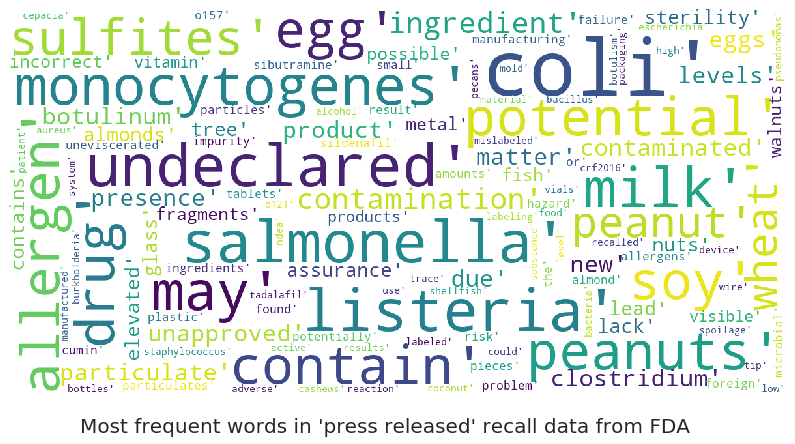

In [269]:
# Visualize the top 200 frequent words in the press released reason sentenses
show_wordcloud(words_press_released_sorted[:200], title = "Most frequent words in 'press released' recall data from FDA")

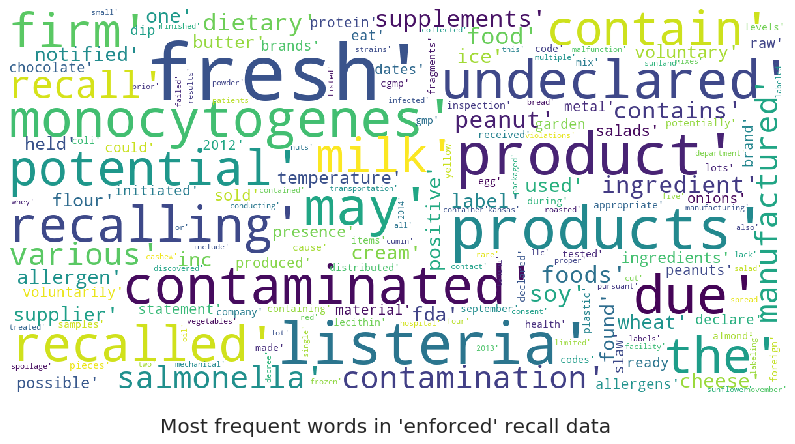

In [271]:
# Visualize the top 200 frequent words in the enforced reason sentenses
show_wordcloud(words_enforced_sorted[:200], title = "Most frequent words in 'enforced' recall data")

Here, we got words lists from both the press released dataset and the enforced dataset. We can see that these words strongly connect to health problems.  
Then, in these lists, there might be some usuless words that appear few times. Let's check these words and delete them.

In [272]:
# Count all of the words in each list
counts_press_released = pd.Series([count for word, count in press_released_sorted if len(word)>2])
counts_enforced = pd.Series([count for word, count in enforced_sorted if len(word)>2])

Text(0.5, 1.0, 'Histogram of counts of words appear in the enforced dataset')

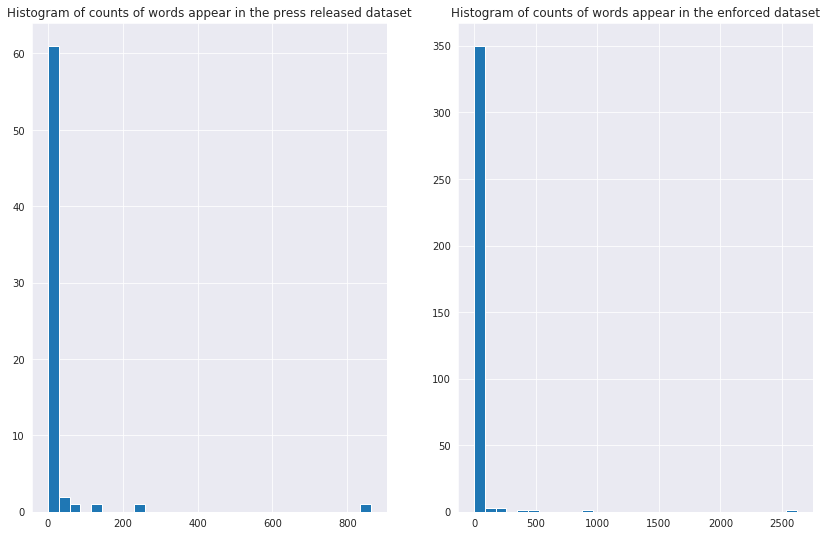

In [284]:
# Plot the histograms of word counts in each list
plt.figure(figsize=(14, 9))

plt.subplot(1,2,1)
counts_press_released.value_counts().hist(bins=30)
plt.title("Histogram of counts of words appear in the press released dataset")

plt.subplot(1,2,2)
counts_enforced.value_counts().hist(bins=30)
plt.title("Histogram of counts of words appear in the enforced dataset")

In [274]:
print("The ratio of words that appear only once in words_press_released_sorted is {:.1f}%".format(counts_press_released.value_counts()[1]/len(words_press_released_sorted)*100))
print("The ratio of words that appear only once in words_enforced_sorted is {:.1f}%".format(counts_enforced.value_counts()[1]/len(words_enforced_sorted)*100))

The ratio of words that appear only once in words_press_released_sorted is 55.6%
The ratio of words that appear only once in words_enforced_sorted is 36.3%


In [275]:
# Let's see inside the press released  word list with specified word count 2 & 3
words_press_released_3 = [word for word, count in press_released_sorted if count==3 if len(word)>2]
words_press_released_4 = [word for word, count in press_released_sorted if count==4 if len(word)>2]

In [276]:
# Let's see inside the enforced word list with specified word count 5 & 10
words_enforced_5 = [word for word, count in enforced_sorted if count==5 if len(word)>2]
words_enforced_10 = [word for word, count in enforced_sorted if count==10 if len(word)>2]
words_enforced_15 = [word for word, count in enforced_sorted if count==15 if len(word)>2]

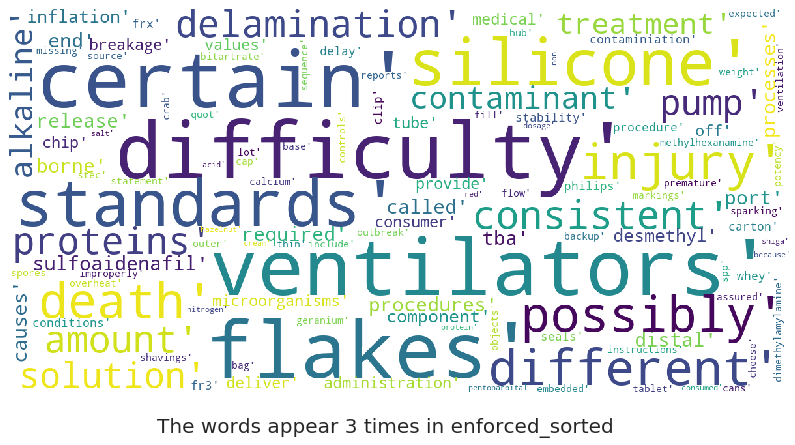

In [277]:
show_wordcloud(words_press_released_3, title = "The words appear 3 times in enforced_sorted")

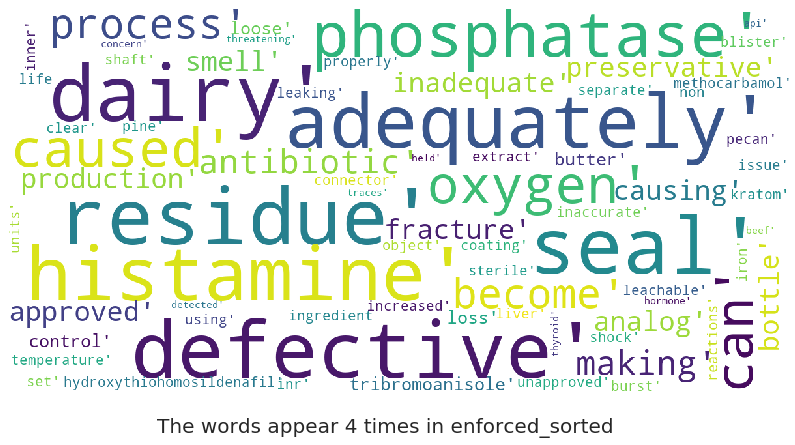

In [278]:
show_wordcloud(words_press_released_4, title = "The words appear 4 times in enforced_sorted")

Here, from count more than 4, the useless words ratio like "become" and "process" is small. (When we increase the minimum count like 10, we still have some useless words, so we analyzed compromise point to get useful health words.)

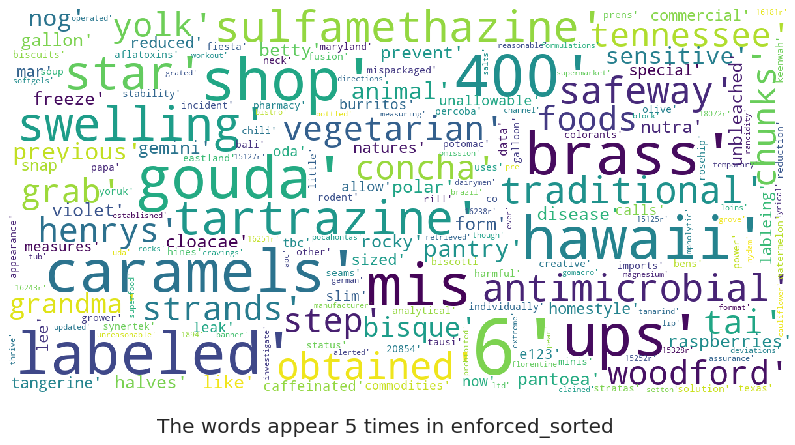

In [279]:
show_wordcloud(words_enforced_5, title = "The words appear 5 times in enforced_sorted")

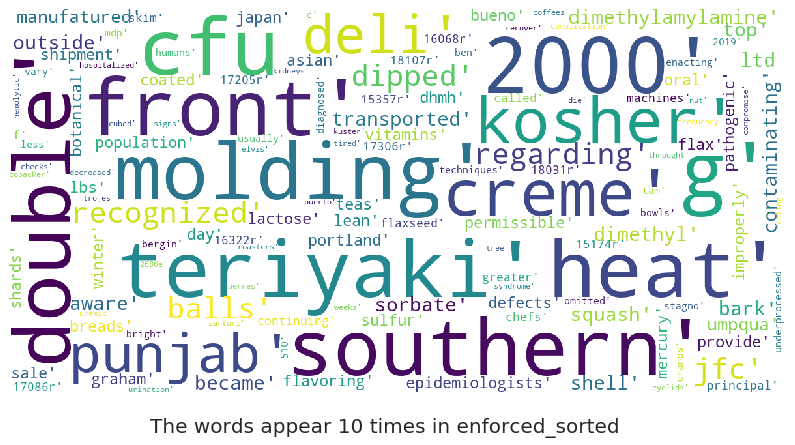

In [280]:
show_wordcloud(words_enforced_10, title = "The words appear 10 times in enforced_sorted")

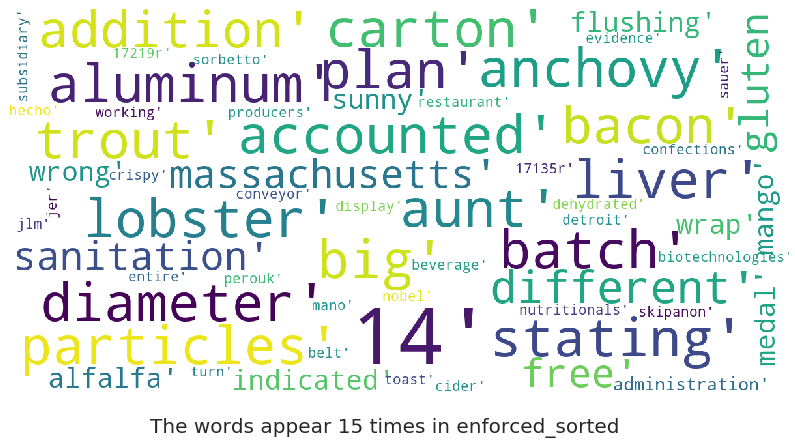

In [281]:
show_wordcloud(words_enforced_15, title = "The words appear 15 times in enforced_sorted")

Here, from count more than 15, the useless words ratio like "14" and "massachusetts" is small. (When we increase the minimum count like 20, we still have some useless words, so we analyzed compromise point to get useful health words.)

In [285]:
frequent_words_press_released = [word for word, count in press_released_sorted if count >= 4 if len(word)>2]
frequent_words_enforced = [word for word, count in enforced_sorted if count >= 30  if len(word)>2]

In [286]:
stemmed['FDA_press_released'] = stemmed['reviewStemmed'].apply(lambda x: [i for i in x if i in frequent_words_press_released])
stemmed['FDA_enforced'] = stemmed['reviewStemmed'].apply(lambda x: [i for i in x if i in frequent_words_enforced])

In [287]:
stemmed.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed,afinnWords,afinnScores,afinnTotalScore,afinnWordsLen,afinnMeanScore,FDA_press_released,FDA_enforced
9,A33NXNZ79H5K51,616719923X,I love green tea I love Kit Kats but the two...,1,2012-09-19,[[Grocery & Gourmet Food]],NaN,22,Not Frequent (1-50),"[love, green, tea, love, kit, kats, two, belon...","[love, love, hate]","[3, 3, -3]",3.0,3,1.0,[],"[green, tea, kit, two, taste]"
32,A14YSMLYLJEMET,B00004S1C5,This product is no where near natural organi...,1,2013-03-29,"[[Grocery & Gourmet Food, Cooking & Baking, Fo...",HIC Harold Import Co.,103,Not Frequent (1-50),"[this, product, near, natural, organic, wish, ...","[no, natural, wish, want, natural, avoid, avoi...","[-1, 1, 1, 1, 1, -1, -1, 2, 2]",5.0,9,1.0,"[product, contains, ingredient, yellow, cause,...","[this, product, natural, organic, contains, th..."
75,A3OH4OZFZGEH75,B0000CCZYY,Licorice is my favorite candy and it promotes...,1,2013-04-05,[[Grocery & Gourmet Food]],Panda,93,Not Frequent (1-50),"[licorice, favorite, candy, promotes, good, di...","[favorite, promotes, good, stronger, nice, ter...","[2, 1, 3, 2, 3, -3, 2]",10.0,7,1.0,"[the, the, package, package]","[candy, good, since, eat, brand, flavor, the, ..."
82,A2OUNVRPRWH0,B0000CCZYY,This is an awesome product natural not a lot...,1,2013-05-07,[[Grocery & Gourmet Food]],Panda,185,Not Frequent (1-50),"[this, awesome, product, natural, lot, ingredi...","[awesome, natural, good, sweet, no, love, hone...","[4, 1, 3, 2, -1, 3, 2, -2, -2, -2, -3, 1, -2, ...",7.0,19,0.0,"[product, ingredients, product, new, could, gr...","[this, product, natural, lot, ingredients, goo..."
85,AX04H2SPKO02S,B0000CD06J,As soon as I had a couple of sips my eczema s...,1,2013-03-06,"[[Grocery & Gourmet Food, Beverages, Coffee, C...",Cafix,33,Not Frequent (1-50),"[as, soon, couple, sips, eczema, started, unco...",[free],[1],1.0,1,1.0,"[not, gluten]","[one, eat, gluten, free, item]"


In [288]:
l_stemmed_press_released = stemmed['FDA_press_released'].values.tolist()
l_stemmed_press_released = flatten(l_stemmed_press_released)

l_stemmed_enforced = stemmed['FDA_enforced'] .values.tolist()
l_stemmed_enforced = flatten(l_stemmed_enforced)

In [289]:
print(len(set(l_stemmed_press_released)))

259


In [290]:
print(len(set(l_stemmed_enforced)))

800


## D Classification

Now that we have created some labelled data, we are now able to build a classifier to detect reviews that expose potential health threaths. This will serve as both a way to handle potentially new reviews, but also detect reviews that we probably missed earlier. 

Notice that we made a few assumptions during our label creation, which might not always hold. Notice also that our healthConcern category created in empath might not be exhaustive enough to capture all health-related issues. A classifier will help us solve those issues.

The classification will proceed in the following steps : 
* First, we start by processing the reviews (removing stopwords, stemming etc..) to have them in a standardized representation.
* Then, we will use **Word2vec** to transform the processed reviews into a numerical features spaces.
* Finally, we will train a **RandomForest** classifier using our labelled data, and use it to classify the rest of our reviews.

We start with the usual steps : reading in our data and removing column that we won't use to save memory space.

In [4]:
empath = pd.read_pickle('drive/My Drive/empath')

empath.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",5,2013-10-11,[[Grocery & Gourmet Food]],NaN,0.0,0.0
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",5,2012-12-06,[[Grocery & Gourmet Food]],NaN,0.0,NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,0.0,NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN,0.0,0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN,0.0,NaN


In [5]:
empath = empath.drop(labels=['unixReviewTime', 'categories', 'brand', 'overall'], axis=1)

empath.head()

,reviewerID,asin,reviewText,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN


We now process our reviews : 
* We first tokenize the sentences into words (not that this process is more sophisticated than simply separating words based on space).
* We then lowercase all tokens and remove those that we deem useless (those that contain only punctuation and the single characters tokens)
* Finally, we stem all the tokens.

In [11]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

stop_words = set(stopwords.words('english')) 

stemmer = PorterStemmer()

def process_text(sentence):
    token_words = nltk.word_tokenize(sentence)
    no_stopwords = [word.lower() for word in token_words if word not in stop_words and not \
                    all(c in string.punctuation for c in word) and not len(word) < 2]
    return [stemmer.stem(word) for word in no_stopwords]

print(process_text('I ordered spongbob slippers and I got John'))

['order', 'spongbob', 'slipper', 'got', 'john']


In [12]:
empath['tokenReviews'] = empath['reviewText'].apply(lambda x : process_text(x))

empath.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ..."
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,..."


Now that we have processed our reviews, we will use **Word2Vec** to transform them into a numerical feature space that we will be able to use in our classification process.

The main reason to use Word2Vec for this step (instead of something like a simple BOW/TF-IDF scheme) was for its ability to capture context effectively and give similar representation to words with similar context. In our application, we want to be able to detect many differents possible threats which may be represented by different words, but will most likely share the same context. Thus, we needed a representation that focuses on that aspect. 

In [15]:
from gensim.models import Word2Vec

size=100

model = Word2Vec(empath['tokenReviews'].values, min_count=1, size=size)

print(model)

Word2Vec(vocab=511855, size=100, alpha=0.025)


Now that we have been able to associate a feature vector to each word, we will use a simple (yet effective) scheme to associate features vectors to complete reviews : simply take all the features vectors of its tokens, and average them.

In [17]:
def token_to_vectors(x):
    arr = []
    for word in x:
        if word in model.wv.vocab:
            arr.append(model.wv[word])
    if (len(arr) == 0):
        return np.zeros((size,))
    return np.array(arr).mean(axis=0)

print(token_to_vectors(['gmo', 'undisputed']))

[-0.04402099 -3.8415065  -5.467218   -1.3234435   1.9598614  -1.332723
  2.0610793  -1.1682926  -2.2003584   2.4413273   0.20715532  3.3212528
 -1.2224286   2.638012    0.7927386   2.580944   -0.3779589  -2.593872
 -0.54438     0.43381268  2.6893     -1.9064891  -3.310894    0.507299
  0.8520623  -0.25355816 -4.934345   -1.1224589   1.1241015  -0.8427675
  0.92275983  1.6497685  -3.6747909  -5.64894    -0.6884977  -0.13964067
 -2.049497    1.058169   -1.0222832   0.29756078  1.5104594  -2.6639192
 -2.5842166  -3.722186    1.9064506  -1.0038728  -2.3591323   3.1446831
  1.8132597  -4.6179056  -0.63248193  1.8198811   2.5830512   1.3222747
  2.758876    2.8688314   1.0363625   1.0974296  -0.9990008  -2.7074764
 -0.6733885  -0.6523644   1.749059   -0.33799282 -0.08485289  0.9892475
 -3.85351     2.852966   -2.5171382  -2.5297549  -1.3684621   0.39454022
  4.573968    0.87234485 -0.72909164  2.8941681  -0.16098817  0.28779116
  2.7012954   1.0207574   1.5668892  -2.2837398  -2.2626593  -1.

In [18]:
empath['feature'] = empath['tokenReviews'].apply(lambda x : token_to_vectors(x))

empath.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053..."
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."


Now onto our classification process : we first start by creating our training set, which simply consists of all the reviews labelled in part C1.

In [19]:
train = empath[~empath['danger'].isna()]

train.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456..."
6,A3LZA698SQPCXE,1453060464,My wife picked some of this up on sale. I usu...,0.0,0.0,"[my, wife, pick, sale, usual, drink, crystal, ...","[1.3866923, 0.019513289, -0.98902005, -0.86818..."
19,A2IPE2KFGTZMI3,3295000018,"Fast and hot, did I mention hot, well it's hot",0.0,0.0,"[fast, hot, mention, hot, well, 's, hot]","[0.07104542, -1.3793547, 1.2464379, -0.8240789..."
23,A2H05FXY2BXUAN,3295000018,High quality! worth every penny you pay for it...,0.0,0.0,"[high, qualiti, worth, everi, penni, pay, the,...","[0.19685604, -0.27718312, -0.36387432, 0.29339..."


Then, we will split into an 90%-10% training/validation sets. Notice that for the splitting process, we use a **stratify** sampling strategy : to avoid having no reviews exposing health danger in either of the sets, we stratify on our danger column to make sure that each of the different values of that columns are proportionally equally represented.

In [ ]:
from sklearn.model_selection import train_test_split

stratify_parameter = train.danger

X = np.array(train['feature'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, train['danger'].astype(int).values, \
                                                    test_size=0.1, random_state=10, \
                                                   stratify=stratify_parameter)

And finally, train our classifier on the training data : 

In [21]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100, random_state=10)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

Once trained, we use our validation set to check the accuracy of our classifier, which yields a 91% accuracy (which is *really* good) :

In [22]:
from sklearn.metrics import accuracy_score

y_pred = classifier.predict(X_test)

print("Accuracy on validation set : {0:.3f}".format(accuracy_score(y_test, y_pred)))

Accuracy on validation set : 0.911


Finally, we create our test set using the reviews yet to be classified...

In [23]:
test = empath[empath['danger'].isna()]

test.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."
5,A3DTB6RVENLQ9Q,1453060375,Don't buy this item - rip off at this price. ...,0.0,NaN,"[do, n't, buy, item, rip, price, my, bad, mist...","[0.6653651, 0.7529061, 0.08680784, -0.06787298..."
7,A2XZPK86YY9R6G,1453060782,I bought these on sale (2 for $4) at my local ...,0.0,NaN,"[bought, sale, local, supermarket, probabl, ov...","[0.732765, 0.1461897, -0.9984229, 0.028604036,..."


...and use our classifier to classify those reviews :

In [ ]:
X_testing_set = np.array(test['feature'].tolist())

test_pred = classifier.predict(X_testing_set)

In [27]:
test['danger'] = test_pred

test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,0,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,0,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."
5,A3DTB6RVENLQ9Q,1453060375,Don't buy this item - rip off at this price. ...,0.0,0,"[do, n't, buy, item, rip, price, my, bad, mist...","[0.6653651, 0.7529061, 0.08680784, -0.06787298..."
7,A2XZPK86YY9R6G,1453060782,I bought these on sale (2 for $4) at my local ...,0.0,0,"[bought, sale, local, supermarket, probabl, ov...","[0.732765, 0.1461897, -0.9984229, 0.028604036,..."


Now that we have classified our test set, we will merge it back into our original dataframe :

In [31]:
final = pd.merge(empath, test, how='left', on=['reviewerID', 'asin'])

final.head()

,reviewerID,asin,reviewText_x,healthScore_x,danger_x,tokenReviews_x,feature_x,reviewText_y,healthScore_y,danger_y,tokenReviews_y,feature_y
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053...",NaN,NaN,NaN,NaN,NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649...","This is my absolute, undisputed favorite tea r...",0.0,0.0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801...",I ordered spongbob slippers and I got John Cen...,0.0,0.0,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456...",NaN,NaN,NaN,NaN,NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094...",This product by Archer Farms is the best drink...,0.0,0.0,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."


In [32]:
final = final.drop(['reviewText_y', 'healthScore_y', 'tokenReviews_y', 'feature_y'], axis=1)

final.head()

,reviewerID,asin,reviewText_x,healthScore_x,danger_x,tokenReviews_x,feature_x,danger_y
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053...",NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649...",0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801...",0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456...",NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094...",0.0


In [34]:
final = final.rename(columns={'reviewText_x': 'reviewText', 'healthScore_x': 'healthScore', 'danger_x': 'danger', 'tokenReviews_x': 'tokenReviews', 'feature_x': 'feature'})

final.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature,danger_y
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053...",NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649...",0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801...",0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456...",NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094...",0.0


In [35]:
final['danger'] = np.where(final['danger'].isna(), final['danger_y'], final['danger'])

final.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature,danger_y
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053...",NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,0.0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649...",0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,0.0,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801...",0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456...",NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,0.0,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094...",0.0


In [36]:
final = final.drop('danger_y', axis=1)

final.head()

,reviewerID,asin,reviewText,healthScore,danger,tokenReviews,feature
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.60243124, 0.03692118, -0.24325879, -0.34053..."
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",0.0,0.0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.5366168, 0.16701524, -0.8955649, -0.5255649..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,0.0,0.0,"[order, spongbob, slipper, got, john, cena, ha...","[0.4629547, 0.47524476, -0.34366208, -0.917801..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.6803912, 0.49300256, -0.93618053, -0.213456..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,0.0,0.0,"[thi, product, archer, farm, best, drink, mix,...","[0.35368785, -0.30620185, -1.6470834, 0.408094..."


Once our merging process is done, let's make sure that all our reviews are indeed classified : 

In [43]:
print("Does column 'danger' still contains nan values ? > {}".format(final['danger'].isna().any()))

Does column 'danger' still contains nan values ? > False


As a side note, notice that our merging process is only possible because the combination (reviewerID, asin) is an index of our dataframe, and thus there is a unique review for each combination of reviewer and product : 

In [3]:
empath.set_index(['reviewerID', 'asin']).index.is_unique

True

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1d5275048>]],
      dtype=object)

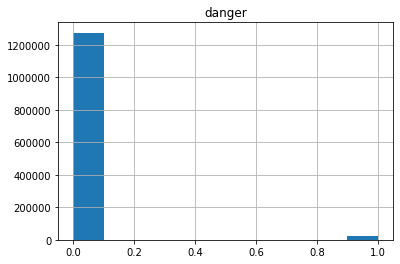

In [42]:
final['danger'] = final['danger'].astype(np.int8)
final.hist(column='danger')

We now have a quick look at the final result.

We see that we have a total of 21'337 reviews presenting health-related threats, which represents 1.67% of the total of reviews. Note that this is the kind of result we expected : only a small number of the reviews present such danger. 

Notice also that we initially labelled 14'607 reviews as health-threatening using empath, thus our classifier was able to find ~7'000 additional. 

In [48]:
threats = len(final[final['danger'] == 1])

print("Number of reviews presenting health threats : {}".format(threats))
print("Number of reviews : {}".format(len(final)))
print("Percentage : {0:.3f}%".format(threats*100/len(final)))

Number of reviews presenting health threats : 21337
Number of reviews : 1297156
Percentage : 1.645%
